In [1]:
import os
os.path

<module 'ntpath' from 'C:\\Users\\ankan\\Anaconda3\\lib\\ntpath.py'>

In [2]:
os.chdir('C:\\Users\\ankan\\Desktop\\Stack')

In [3]:
from wordcloud import WordCloud
import sqlite3
import re
import pandas as pd
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
import warnings
import csv
from PIL import Image

In [5]:
data = pd.read_csv('data_100k_finally_filtered.csv')

In [6]:
data.head()

,Unnamed: 0,Title,Body,Tags,Question,tag_count
0,0,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...,how to check if an upload file is an imag with...,5
1,1,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox,how can i prevent firefox from close when i pr...,1
2,2,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning,r error invalid type list for variabl i am imp...,3
3,3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding,how do i replac special charact in a url this ...,3
4,4,How to modify whois contact details?,<pre><code>function modify(.......)\r\r\n{\r\r...,php api file-get-contents,how to modifi whoi contact detail function mod...,3


In [7]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(data['Tags'])

In [8]:
multilabel_y

<99436x18448 sparse matrix of type '<class 'numpy.int64'>'
	with 286677 stored elements in Compressed Sparse Row format>

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [9]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [10]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [11]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

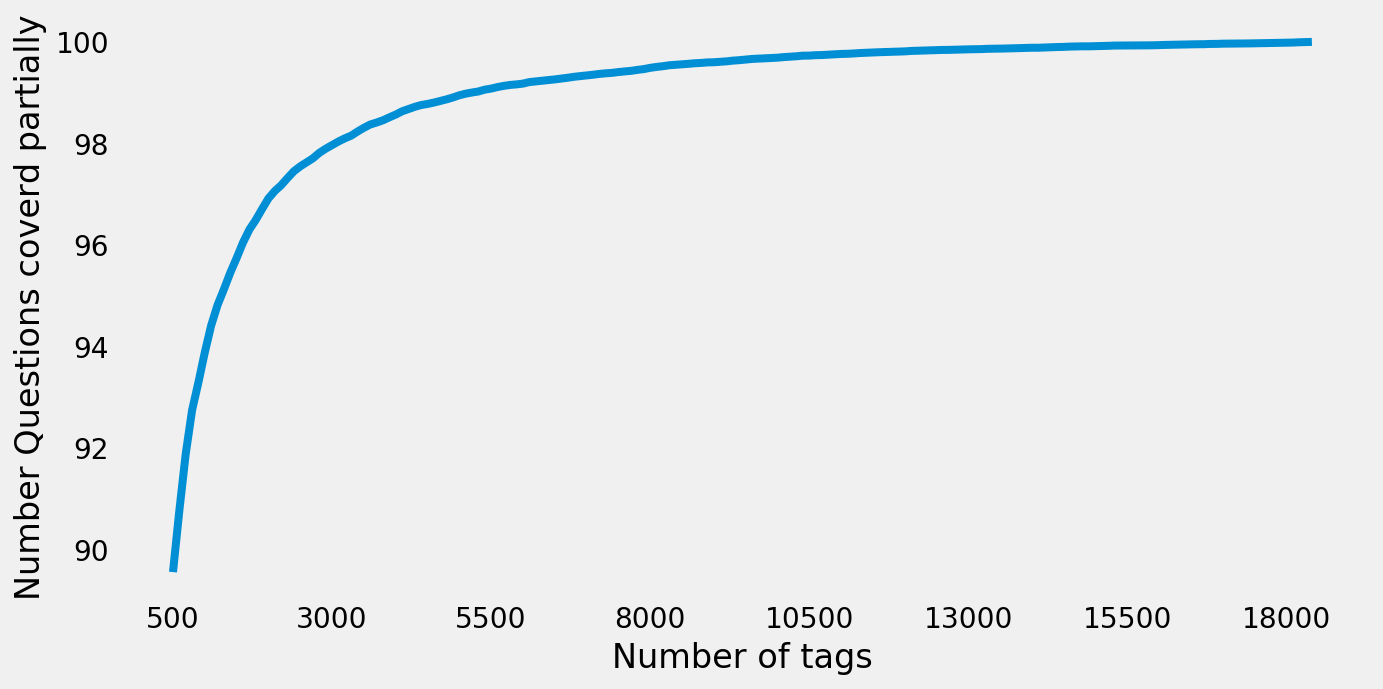

In [12]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()

In [13]:
# we can choose any number of tags based on your computing power, minimun is 500(it covers almost 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

with  5500 tags we are covering  99.079 % of questions
with  500 tags we are covering  89.551 % of questions


In [14]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 10390 out of  99436


In [15]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 18448
number of tags taken : 500 ( 2.7103209019947965 %)


In [16]:
total_size=data.shape[0]
train_size=int(0.80*total_size)

x_train=data.head(train_size)
x_test=data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)


Number of data points in train data : (79548, 500)
Number of data points in test data : (19888, 500)


__Using bag of words upto 4 grams and compute the micro f1 score with Logistic regression(OvR)__

In [33]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=20000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['Question'])
x_test_multilabel = vectorizer.transform(x_test['Question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:27.329954


__Performing hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch__

In [18]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

tuned_parameters = dict(estimator__C=[10**-4, 10**-2, 10**0, 10**2, 10**4])
model = GridSearchCV(OneVsRestClassifier(LogisticRegression(n_jobs = -1)), tuned_parameters, cv = 3,
                      n_jobs = -1)
model.fit(x_train_multilabel, y_train)
print(model.best_estimator_)


print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)
------------------------------------------------------------------------
Time taken to run this cell :
 3:48:34.448644
------------------------------------------------------------------------


In [22]:
#https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/discussion/6650

In [18]:

import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import scikitplot as skplt



In [30]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(C = 100, penalty='l2', n_jobs=-1), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))



print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.21656275140788414
Hamming loss  0.002988938053097345
Micro-average quality numbers
Precision: 0.6464, Recall: 0.3602, F1-measure: 0.4626
Macro-average quality numbers
Precision: 0.5261, Recall: 0.2297, F1-measure: 0.3040
Macro-average quality numbers
Precision: 0.5261, Recall: 0.2297, F1-measure: 0.3040
             precision    recall  f1-score   support

          0       0.54      0.45      0.49      1559
          1       0.64      0.52      0.57      1330
          2       0.73      0.62      0.67      1323
          3       0.59      0.46      0.52      1250
          4       0.93      0.79      0.85      1041
          5       0.81      0.66      0.73      1017
          6       0.79      0.57      0.66       644
          7       0.83      0.63      0.72       619
          8       0.59      0.46      0.52       587
          9       0.66      0.44      0.53       610
         10       0.74      0.54      0.62       551
         11       0.37      0.23      0.29   

__Trying OneVsRestClassifier with Linear-SVM (SGDClassifier with loss-hinge)__

In [56]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy : 0.1993161705551086
Hamming loss  0.0030262469831053903
Micro-average quality numbers
Precision: 0.8033, Recall: 0.2022, F1-measure: 0.3231
Macro-average quality numbers
Precision: 0.1915, Recall: 0.0789, F1-measure: 0.1035
             precision    recall  f1-score   support

          0       0.75      0.09      0.16      1559
          1       0.74      0.40      0.52      1330
          2       0.77      0.55      0.64      1323
          3       0.72      0.33      0.45      1250
          4       0.92      0.75      0.82      1041
          5       0.82      0.60      0.69      1017
          6       0.84      0.48      0.61       644
          7       0.83      0.61      0.70       619
          8       0.72      0.27      0.39       587
          9       0.81      0.36      0.50       610
         10       0.81      0.51      0.63       551
         11       0.00      0.00      0.00       531
         12       1.00      0.00      0.00       548
         13       1.00 

In [57]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.0001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy : 0.20017095736122284
Hamming loss  0.0030234312148028964
Micro-average quality numbers
Precision: 0.8046, Recall: 0.2027, F1-measure: 0.3239
Macro-average quality numbers
Precision: 0.1982, Recall: 0.0810, F1-measure: 0.1059
             precision    recall  f1-score   support

          0       0.75      0.10      0.17      1559
          1       0.74      0.39      0.51      1330
          2       0.77      0.56      0.65      1323
          3       0.73      0.33      0.45      1250
          4       0.92      0.75      0.82      1041
          5       0.82      0.60      0.69      1017
          6       0.82      0.50      0.62       644
          7       0.82      0.61      0.70       619
          8       0.71      0.27      0.39       587
          9       0.80      0.35      0.49       610
         10       0.80      0.49      0.61       551
         11       0.00      0.00      0.00       531
         12       0.00      0.00      0.00       548
         13       0.50

In [58]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy : 0.12987731295253419
Hamming loss  0.0034298069187449717
Micro-average quality numbers
Precision: 0.8515, Recall: 0.0481, F1-measure: 0.0911
Macro-average quality numbers
Precision: 0.0156, Recall: 0.0034, F1-measure: 0.0051
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1559
          1       0.78      0.18      0.30      1330
          2       0.77      0.28      0.41      1323
          3       0.80      0.09      0.17      1250
          4       0.93      0.52      0.67      1041
          5       0.87      0.16      0.27      1017
          6       0.00      0.00      0.00       644
          7       0.91      0.24      0.37       619
          8       0.85      0.03      0.06       587
          9       0.00      0.00      0.00       610
         10       0.89      0.19      0.31       551
         11       0.00      0.00      0.00       531
         12       0.00      0.00      0.00       548
         13       0.00

In [63]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha = 100, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print('------------------------------------------------------------------------')
print("Time taken to run this cell :\n", datetime.now() - start)
print('------------------------------------------------------------------------')

Accuracy : 0.00045253419147224457
Hamming loss  0.00556446098149638
Micro-average quality numbers
Precision: 0.0018, Recall: 0.0010, F1-measure: 0.0013
Macro-average quality numbers
Precision: 0.0000, Recall: 0.0020, F1-measure: 0.0000
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1559
          1       0.00      0.00      0.00      1330
          2       0.00      0.00      0.00      1323
          3       0.00      0.00      0.00      1250
          4       0.00      0.00      0.00      1041
          5       0.00      0.00      0.00      1017
          6       0.00      0.00      0.00       644
          7       0.00      0.00      0.00       619
          8       0.00      0.00      0.00       587
          9       0.00      0.00      0.00       610
         10       0.00      0.00      0.00       551
         11       0.00      0.00      0.00       531
         12       0.00      0.00      0.00       548
         13       0.0